In [1]:
from collections import namedtuple
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
from scipy.optimize import fmin_powell
import seaborn as sns
from sklearn.linear_model import LogisticRegression

%matplotlib inline
plt.style.use('seaborn')

In [2]:
# simulate data

In [3]:
PRESIDENT_PROBABILITY = .05
ACCIDENT_PROBABILITY = .12
TRAFFIC_PROBABILITY = {(0, 0): .15, (0, 1): .5, (1, 0): .6, (1, 1): .9}
TRIALS = 200

In [4]:
JointInput = namedtuple('JointInput', ['p', 'a'])

In [5]:
president = np.random.binomial(n=1, p=PRESIDENT_PROBABILITY, size=TRIALS)
accident = np.random.binomial(n=1, p=ACCIDENT_PROBABILITY, size=TRIALS)

traffic_probabilities = [TRAFFIC_PROBABILITY[JointInput(p=p, a=a)] for p, a in zip(president, accident)]
traffic = np.random.binomial(n=1, p=traffic_probabilities)

In [6]:
print( f'President Mean: {president.mean()}' )
print( f'Accident Mean: {accident.mean()}' )
print( f'Traffic Mean: {traffic.mean()}')

President Mean: 0.035
Accident Mean: 0.085
Traffic Mean: 0.195


In [7]:
observed_data = pd.DataFrame({'president': president, 'accident': accident, 'traffic': traffic})

In [8]:
# probabilities are no longer fixed values, but distributions

In [9]:
times_president_observed = sum(president)
times_president_not_observed = len(president) - times_president_observed

president_probability_samples = np.random.beta(
    a=1 + times_president_observed, 
    b=1 + times_president_not_observed, 
    size=4000
)

In [10]:
times_accident_observed = sum(accident)
times_accident_not_observed = len(accident) - times_accident_observed

accident_probability_samples = np.random.beta(
    a=1 + times_accident_observed, 
    b=1 + times_accident_not_observed, 
    size=4000
)

In [11]:
# P(traffic | accident, president)

In [12]:
# logistic regression baseline

glm = LogisticRegression()
_ = glm.fit(X=observed_data[['president', 'accident']], y=observed_data['traffic'])

In [13]:
precision = 5
print( f'Estimated intercept: {glm.intercept_[0]:.{precision}}' )
print( f'Estimated president coefficient: {glm.coef_[0][0]:.{precision}}' )
print( f'Estimated accident coefficient: {glm.coef_[0][1]:.{precision}}' )

Estimated intercept: -1.5196
Estimated president coefficient: 1.1461
Estimated accident coefficient: 0.93112


In [14]:
with pm.Model() as model:
    pm.glm.glm('traffic ~ president + accident', observed_data, family=pm.glm.families.Binomial())
    start_MAP = pm.find_MAP(fmin=fmin_powell, disp=False)
    step = pm.NUTS(scaling=start_MAP)
    trace = pm.sample(2000, step=step, njobs=2, progressbar=True)

100%|██████████| 2000/2000 [00:07<00:00, 277.03it/s]


In [15]:
# i'm not sure why, but everything seems to go to hell when i have `njobs=4`

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11b97fc88>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x10f284940>]], dtype=object)

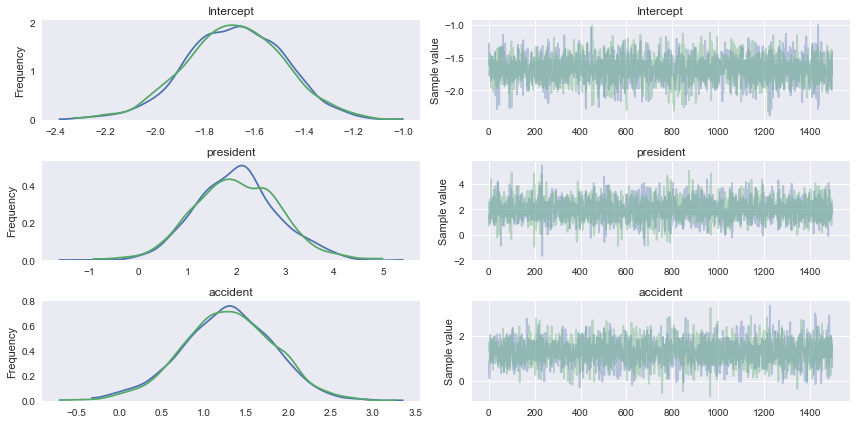

In [16]:
warmup = 500
variables = ['Intercept', 'president', 'accident']

pm.traceplot(trace[warmup:], varnames=variables)

In [17]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def compute_counterfactual_predictions(president_value, accident_value, trace=trace):
    log_odds_p = trace['Intercept'] + trace['president']*president_value + trace['accident']*accident_value
    return sigmoid(log_odds_p)

def compute_prediction_interval(predictions, percentile=94):
    lower_percentile_bound = (100 - percentile) / 2
    upper_percentile_bound = 100 - lower_percentile_bound
    return np.percentile(predictions, lower_percentile_bound), np.percentile(predictions, upper_percentile_bound)

In [18]:
input_combinations = [(0, 0), (0, 1), (1, 0), (1, 1)]
counterfactual_predictions = {}
observed_proportions = {}

for p, a in input_combinations:
    counterfactual_predictions[JointInput(p=p, a=a)] = compute_counterfactual_predictions(p, a)
    observed_proportions[JointInput(p=p, a=a)] = \
        observed_data[(observed_data['president'] == p) & (observed_data['accident'] == a)]['traffic'].mean()

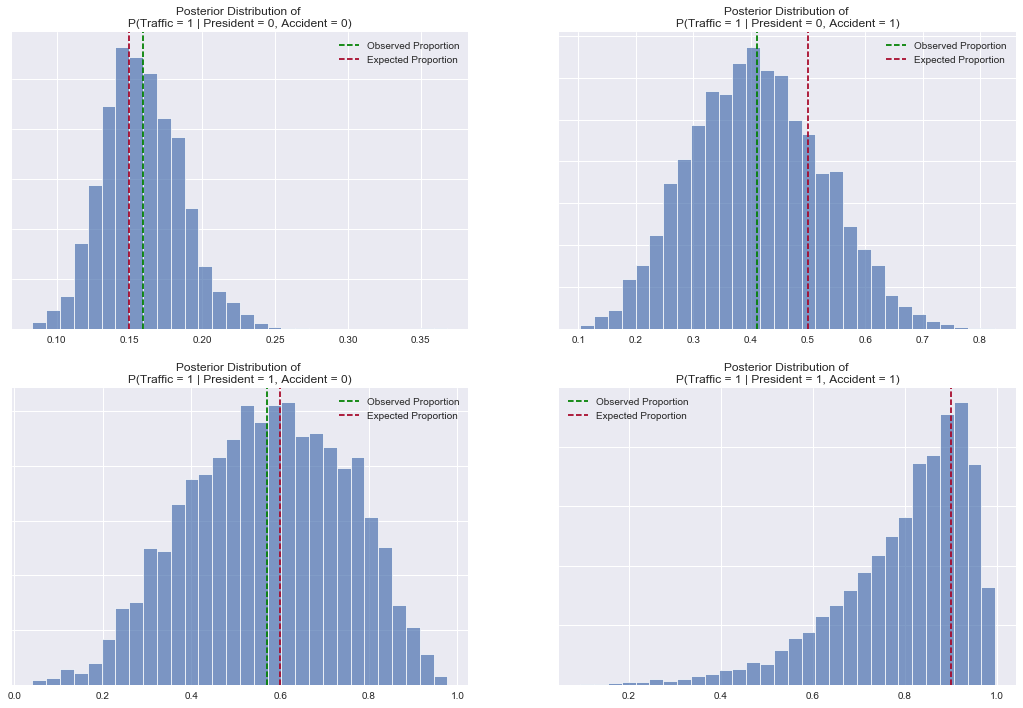

In [19]:
plt.figure(figsize=(18, 12))

for subplot_idx, (p, a) in enumerate([(0, 0), (0, 1), (1, 0), (1, 1)]):
    predictions = counterfactual_predictions[JointInput(p=p, a=a)]
    observed_proportion = observed_proportions[JointInput(p=p, a=a)]
    expected_proportion = TRAFFIC_PROBABILITY[JointInput(p=p, a=a)]
    
    subplot = plt.subplot(221 + subplot_idx)
    plt.setp(subplot.get_yticklabels(), visible=False)
    plt.hist(predictions, edgecolor='white', linewidth=1, bins=30, alpha=.7)
    plt.axvline(observed_proportion, color='green', linestyle='--', label='Observed Proportion')
    plt.axvline(expected_proportion, color='#A60628', linestyle='--', label='Expected Proportion')
    title = 'Posterior Distribution of \nP(Traffic = 1 | President = {}, Accident = {})'.format(p, a)
    plt.title(title)
    plt.legend()

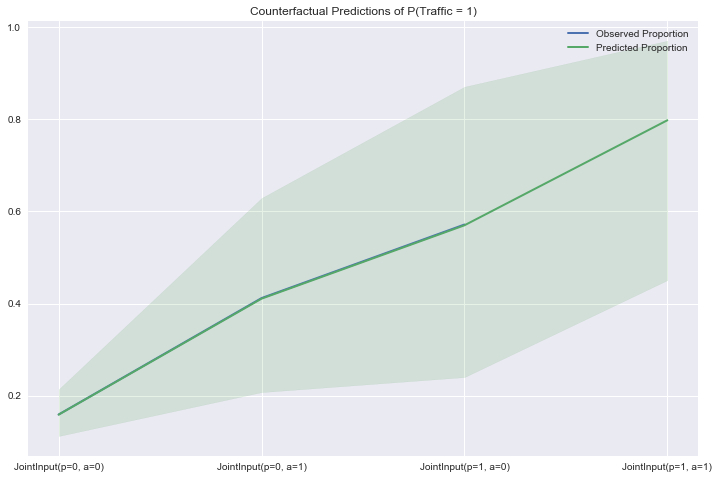

In [20]:
x = [1, 2, 3, 4]
y_observed = list(observed_proportions.values())
labels = list(observed_proportions.keys())

y_predicted_mean = [counterfactual_predictions[joint_input].mean() for joint_input in counterfactual_predictions]
y_predicted_PI = [compute_prediction_interval(counterfactual_predictions[joint_input]) for joint_input in counterfactual_predictions]
y_predicted_PI_lower_bound, y_predicted_PI_upper_bound = zip(*y_predicted_PI)

plt.figure(figsize=(12, 8))
plt.plot(x, y_observed, linewidth=2, label='Observed Proportion')
plt.xticks(x, labels)
plt.plot(x, y_predicted_mean, linewidth=2, label='Predicted Proportion')
plt.fill_between(x, y_predicted_PI_lower_bound, y_predicted_PI_upper_bound, alpha=.1, color='green')
plt.title('Counterfactual Predictions of P(Traffic = 1)')
plt.legend()

# $P(\text{Accident = 1}\ |\ \text{Traffic = 1})$
<br>
$\begin{align*}
P(A = 1|T = 1)
  &= \frac{P(T = 1 | A = 1)P(A = 1)}{P(T = 1)}\\
  &= \frac{P(T = 1, A = 1)P(A = 1)}{P(A = 1)P(T = 1)}\\
  &= \frac{P(T = 1, A = 1)}{P(T = 1)}\\
\end{align*}$
<br>
<br>
<br>
$\begin{align*}
P(T = 1, A = 1)
  &= \sum_{P}P(P, A = 1, T = 1))\\
  &= P(P = 0, A = 1, T = 1) + P(P = 1, A = 1, T = 1)\\
  &= P(P = 0)P(A = 1)P(T = 1 \ |\  P = 0, A = 1) + P(P = 1)P(A = 1)P(T = 1 \ |\  P = 1, A = 1)
\end{align*}$
<br>
<br>
<br>
$\begin{align*}
P(T = 1)
  &= \sum_{A, P}P(A, P, T = 1))\\
  &= \sum_{A, P}P(A)P(P)P(T = 1\ |\ A, P))\\
  &=
    P(A = 0)P(P = 0)P(T = 1\ |\ A = 0, P = 0) + P(A = 0)P(P = 1)P(T = 1\ |\ A = 0, P = 1) + P(A = 1)P(P = 0)P(T = 1\ |\ A = 1, P = 0) + P(A = 1)P(P = 1)P(T = 1\ |\ A = 1, P = 1)
\end{align*}$

In [25]:
def compute_P_accident_1_given_traffic_1(president_probability, accident_probability, traffic_probability):
    P_traffic_1_accident_1 = \
        (1 - president_probability)*(accident_probability)*traffic_probability[JointInput(p=0, a=1)] +\
        (president_probability)*(accident_probability)*traffic_probability[JointInput(p=1, a=1)]

    P_traffic_1 = \
        (1 - accident_probability)*(1 - president_probability)*traffic_probability[JointInput(p=0, a=0)] +\
        (1 - accident_probability)*(president_probability)*traffic_probability[JointInput(p=1, a=0)] +\
        (accident_probability)*(1 - president_probability)*traffic_probability[JointInput(p=0, a=1)] +\
        (accident_probability)*(president_probability)*traffic_probability[JointInput(p=1, a=1)]
    
    P_accident_1_given_traffic_1 = P_traffic_1_accident_1 / P_traffic_1
    
    return P_accident_1_given_traffic_1

In [26]:
P_accident_1_given_traffic_1_point_estimate = \
    compute_P_accident_1_given_traffic_1(PRESIDENT_PROBABILITY,ACCIDENT_PROBABILITY,TRAFFIC_PROBABILITY)
    
P_accident_1_given_traffic_1_with_uncertainty = \
    compute_P_accident_1_given_traffic_1(president_probability_samples, accident_probability_samples, counterfactual_predictions)

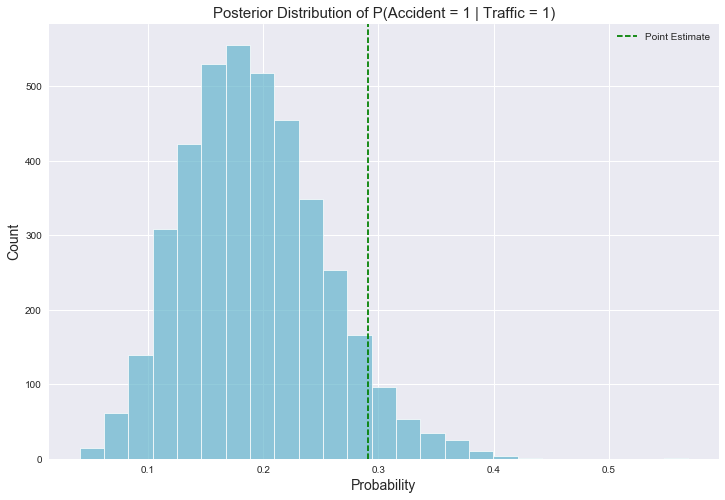

In [43]:
color = sns.color_palette()[-1]

plt.figure(figsize=(12, 8))
plt.hist(P_accident_1_given_traffic_1_with_uncertainty, linewidth=1, bins=25, color=color, edgecolor='white', alpha=.7)
plt.title('Posterior Distribution of P(Accident = 1 | Traffic = 1)', fontsize=15)
plt.axvline(P_accident_1_given_traffic_1_point_estimate, color='green', linestyle='--', label='Point Estimate')
plt.xlabel('Probability', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.legend()

# $P(\text{Accident = 1}\ |\ \text{Traffic = 1}, \text{President = 1})$
<br>
$\begin{align*}
P(A = 1\ |\ T = 1, P = 1)
  &= \frac{P(A = 1, T = 1, P = 1)}{P(T = 1, P = 1)}
\end{align*}$
<br>
<br>
<br>
$\begin{align*}
P(A = 1, T = 1, P = 1)
  &= P(T = 1\ |\ A = 1, P = 1)P(A = 1)P(P = 1)
\end{align*}$
<br>
<br>
<br>
$\begin{align*}
P(T = 1, P = 1)
  &= \sum_{A}P(A, P = 1, T = 1)\\
  &= P(A = 0, P = 1, T = 1) + P(A = 1, P = 1, T = 1)\\
  &= P(T = 1\ |\ A = 0, P = 1)P(P = 1)P(A = 0) + P(T = 1\ |\ A = 1, P = 1)P(P = 1)P(A = 1)
\end{align*}$

In [28]:
def compute_P_accident_1_given_traffic_1_president_1(president_probability, accident_probability, traffic_probability):
    P_accident_1_traffic_1_president_1 = \
        traffic_probability[JointInput(p=1, a=1)]*accident_probability*president_probability
        
    P_traffic_1_president_1 = \
        traffic_probability[JointInput(p=1, a=0)]*president_probability*(1 - accident_probability) +\
        traffic_probability[JointInput(p=1, a=1)]*president_probability*accident_probability
        
    P_accident_1_given_traffic_1_president_1 = P_accident_1_traffic_1_president_1 / P_traffic_1_president_1
    
    return P_accident_1_given_traffic_1_president_1

In [29]:
P_accident_1_given_traffic_1_president_1_point_estimate = \
    compute_P_accident_1_given_traffic_1_president_1(PRESIDENT_PROBABILITY,ACCIDENT_PROBABILITY,TRAFFIC_PROBABILITY)
    
P_accident_1_given_traffic_1_president_1_with_uncertainty = \
    compute_P_accident_1_given_traffic_1_president_1(president_probability_samples, accident_probability_samples, counterfactual_predictions)

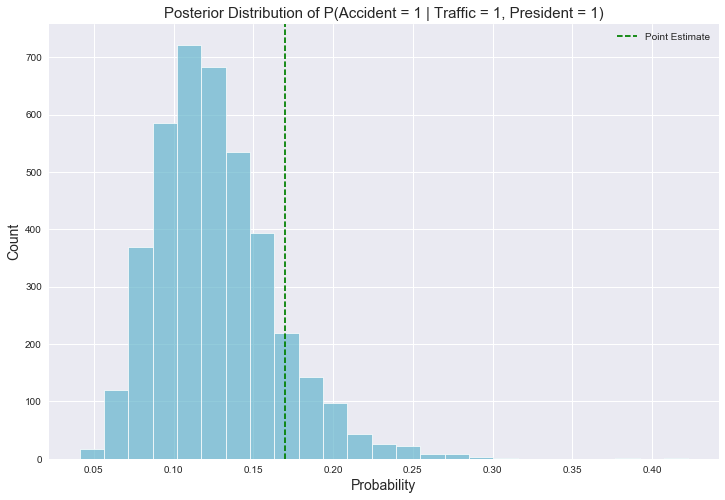

In [44]:
plt.figure(figsize=(12, 8))
plt.hist(P_accident_1_given_traffic_1_president_1_with_uncertainty, 
         bins=25, color=color, linewidth=1, edgecolor='white', alpha=.7)
plt.title('Posterior Distribution of P(Accident = 1 | Traffic = 1, President = 1)', fontsize=15)
plt.axvline(P_accident_1_given_traffic_1_president_1_point_estimate, color='green', linestyle='--', label='Point Estimate')
plt.xlabel('Probability', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.legend()